### import libraries

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.random import randn
from sklearn.model_selection import KFold

### general system for damped oscillator

$
\ddot{x}(t) + 2\zeta\omega_0 \dot{x}(t) + \omega_0^2 x(t) = 0
$

#### Description of variables:
- $ x(t) $: position 
- $ \dot{x}(t) $: Velocity 
- $ \ddot{x}(t) $: acceleration
- $ \zeta $: The damping factor, which determines how quickly the oscillations decay (due to friction or resistance).
- $ \omega_0 $: The natural frequency of the system (eigenfrequency)
- $ t $: Time unit.

In [51]:
zeta = 0*0.2/np.sqrt(2)
omega_0 = 0.2* 2* np.pi
def damped_oscillator(t, x):  #remember that independent value t comes first
    x_dot = - 2* zeta * omega_0 * x[1] - omega_0**2 * x[0] # x'' = -2*z*w0*x' - w0^2 * x rewritten as a system of first order 
    return [x[1], x_dot]  #y[1] = velocity and y_dot = acceleration. return both since system is rewritten as 2 first order diffs.

m = 1
k = m * omega_0**2
c = 2* zeta * np.sqrt(k * m) 

### Solving the differential equation numerically fro scipy

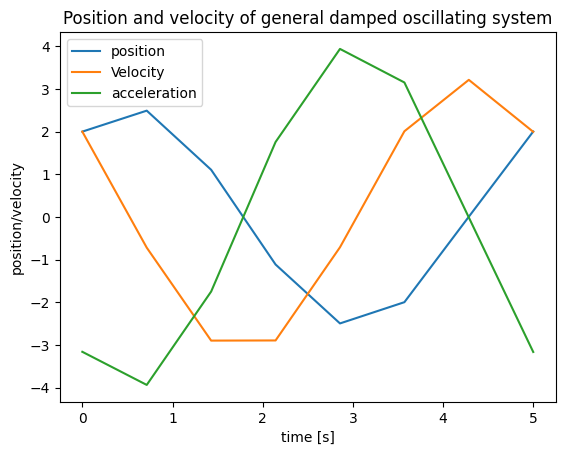

In [68]:
init_values = [2, 2]  # Initial condition [position, velocity]
num_datapoints = 8
timespan = [0, 5]
t = np.linspace(0, 5, num_datapoints)
sol = solve_ivp(damped_oscillator, (t[0], t[-1]), init_values, t_eval = t)#time interval first, then initial values for position and velocity
p  = sol.y[0]
v = sol.y[1]
a = - 2* zeta * omega_0 * v - omega_0**2 * p  #calculating accelerations from positions and velocities

plt.plot(t, p, label = "position")
plt.plot(t, v, label = "Velocity")
plt.plot(t, a, label = "acceleration")
plt.xlabel("time [s]")
plt.ylabel("position/velocity")
plt.title("Position and velocity of general damped oscillating system")
plt.legend()
plt.show()

### Discretizing the dataset with gaussian noise

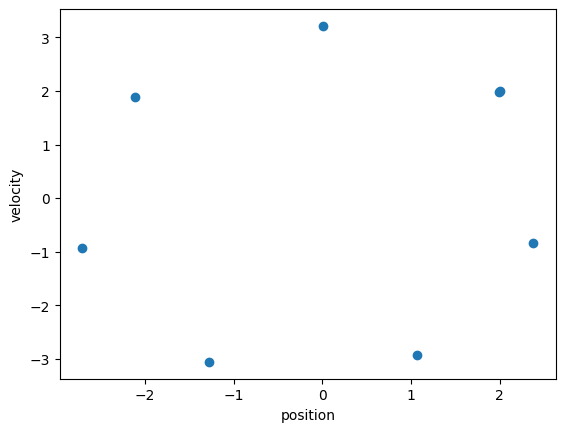

[-0.07181642  0.24577055  0.31501784  1.33083475  0.51159197 -0.56034092
  0.01966038 -0.01879334]


In [70]:
def generate_noisy_data(p, v, a, noise_std=0.1):
    gaussian_noise = np.random.normal(0, noise_std, len(p))
    # Add noise to position, velocity, and acceleration
    p_noisy = p + gaussian_noise
    v_noisy = v + gaussian_noise
    a_noisy = a + gaussian_noise
    
    # Update input and target outputs
    input_data = np.column_stack((p_noisy, v_noisy))
    target_outputs = np.column_stack((v_noisy, a_noisy))
    
    return input_data, target_outputs
    
input_data, target_outputs = generate_noisy_data(p, v, a, noise_std=0.1)
num_states = input_data.shape[1]
plt.plot(input_data[:, 0], input_data[:,1], 'o')
plt.xlabel("position")
plt.ylabel("velocity")
plt.show()
print(input_data[:,1] * (m * target_outputs[:,1] + k * input_data[:, 0]))

### Tuning $\lambda$ and $\sigma$
 - Lambda ($𝜆$): This is the regularization parameter that controls the trade-off between minimizing error on the training data and keeping the model complexity low. Higher $𝜆$ values apply stronger regularization, leading to simpler, smoother solutions that generalize better.

 - Sigma ($𝜎$): In the RBF kernel, $𝜎$, controls the spread of the kernel, defining how quickly similarity decays with distance. Smaller 
$𝜎$ results in a highly localized influence (risking overfitting), whereas larger $𝜎$ smooths the influence over a broader area (which may underfit).

### Computing the rbf kernel and lagrange kernel

In [54]:
def rbf_kernel(x, y, sigma):
    k = np.exp(-(np.linalg.norm(x - y)**2)/(2 * sigma**2))
    return k

def first_partial_derivative(x, u, sigma):
    """Compute the first partial derivative of the RBF kernel with respect to x."""
    kernel_value = rbf_kernel(x, u, sigma)
    return -np.sum((x - u) / sigma**2) * kernel_value

def second_partial_derivative(x, u, sigma):
    """Compute the second partial derivative of the RBF kernel with respect to x."""
    kernel_value = rbf_kernel(x, u, sigma)
    dist_sq = np.sum((x - u)**2)
    return kernel_value * ((dist_sq - sigma**2) / sigma**4)

def lagrangian_kernel(x, u, sigma):
    """Compute the Lagrangian kernel for a damped oscillator."""
    kernel_value = rbf_kernel(x, u, sigma)
    
    # Kinetic term: mass * second partial derivative
    kinetic_term = m * second_partial_derivative(x, u, sigma)
    
    # Potential term: spring constant * kernel value
    potential_term = k * kernel_value
    
    # Damping term: damping coefficient * first partial derivative
    damping_term = c * first_partial_derivative(x, u, sigma)
    
    return kinetic_term + potential_term + damping_term


### find best sigma and lambda by cross validation

In [55]:
sigma_values = [6, 9, 12, 15, 18]
lambda_values = [0.0001, 0.001, 0.01, 0.1]

def loocv_sigma_lambda(input_data, target_outputs, sigma_values, lambda_values, kernel_function):
    N = len(input_data)
    best_sigma, best_lambda = None, None
    lowest_mse = float('inf')

    for sigma in sigma_values:
        for lam in lambda_values:
            mse_fold = []

            for i in range(N):
                # Split into training and testing
                train_data = np.delete(input_data, i, axis=0)
                test_data = input_data[i].reshape(1, -1)  # Single test point
                train_targets = np.delete(target_outputs, i, axis=0)
                test_targets = target_outputs[i].reshape(1, -1)

                # Train model
                K_train = np.array([[kernel_function(x_i, x_j, sigma) for x_j in train_data] for x_i in train_data])
                alpha = np.linalg.solve(K_train + lam * np.eye(len(train_data)), train_targets)

                # Test model
                K_test = np.array([[kernel_function(x_i, x_j, sigma) for x_j in train_data] for x_i in test_data])
                pred_test = np.dot(K_test, alpha)

                # Calculate MSE for this test point
                mse = np.mean((test_targets - pred_test)**2)
                mse_fold.append(mse)

            # Average MSE over all folds
            avg_mse = np.mean(mse_fold)
            if avg_mse < lowest_mse:
                lowest_mse = avg_mse
                best_sigma = sigma
                best_lambda = lam

    return best_sigma, best_lambda, lowest_mse

sigma_r, lam_r, best_mse_r = loocv_sigma_lambda(input_data, target_outputs, sigma_values, lambda_values, rbf_kernel)
sigma_l, lam_l, best_mse_l = loocv_sigma_lambda(input_data, target_outputs, sigma_values, lambda_values, lagrangian_kernel)

print(f"Beste sigma rbf: {sigma_r}")
print(f"Beste lambda rbf: {lam_r}")
print(f"Beste MSE rbf: {best_mse_r}")

print(f"Beste sigma lagrange: {sigma_l}")
print(f"Beste lambda lagrange: {lam_l}")
print(f"Beste MSE lagrange: {best_mse_l}")

#sigma_r, lam_r = [10, 0.0001]
#sigma_l, lam_l = [10, 0.0001]

Beste sigma rbf: 6
Beste lambda rbf: 0.0001
Beste MSE rbf: 0.0080660056519075
Beste sigma lagrange: 6
Beste lambda lagrange: 0.0001
Beste MSE lagrange: 0.008003041349122069


### Compute the gram matrix for lagrange and gauss

In [56]:
def gram(x, sigma, mode):
    n = x.shape[0]
    k_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if mode == "lagrangian":
                k_mat[i, j] = lagrangian_kernel(x[i], x[j], sigma)
            if mode == "rbf":
                k_mat[i, j] = rbf_kernel(x[i], x[j], sigma)
    return k_mat

K_rbf = gram(input_data, sigma_r, "rbf")
K_lagrange = gram(input_data, sigma_l, "lagrangian")

### Solve the minimization problem to obtain dual coefficients $\alpha$

In [57]:
def dual_coeff(K, y, lambd):
    n = K.shape[0]
    K_reg = K + lambd * np.eye(n)
    alpha = np.linalg.solve(K_reg, y)
    return alpha
a_rbf = dual_coeff(K_rbf, target_outputs, lam_r)  
a_lagrange = dual_coeff(K_lagrange, target_outputs, lam_l)

### Estimate the function for acceleration and velocity based on $\alpha$ and the gram matrix

In [66]:
def learned_outputs(x, sigma,alpha, mode):
    f = np.zeros((num_datapoints, num_states))
    for i in range(num_datapoints):
        for j in range(num_datapoints):
            if mode == "lagrangian":
                 kernel_value = lagrangian_kernel(x[i], x[j], sigma)
            if mode == "rbf":
                kernel_value = rbf_kernel(x[i], x[j], sigma)
            f[i] += alpha[j] * kernel_value 
    return f
f_rbf = learned_outputs(input_data, sigma_r, a_rbf, "rbf")
f_lagrange = learned_outputs(input_data, sigma_l, a_lagrange, "lagrangian")


### Solve the learned function to get trajectories

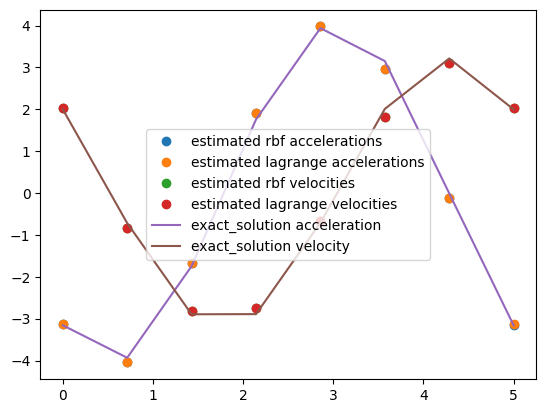

In [59]:
plt.plot(t, f_rbf[:,1],'o', label = "estimated rbf accelerations")
plt.plot(t, f_lagrange[:,1],'o', label = "estimated lagrange accelerations")
plt.plot(t, f_rbf[:,0],'o', label = "estimated rbf velocities")
plt.plot(t, f_lagrange[:,0],'o', label = "estimated lagrange velocities")
plt.plot(t, a, label = "exact_solution acceleration")
plt.plot(t, v, label = "exact_solution velocity")
plt.legend()
plt.show()

### Analytical solution for entire duration

In [60]:
entire_t = np.linspace(0, 30, 200)
entire_span = (entire_t[0], entire_t[-1])
sol_exact = solve_ivp(damped_oscillator, entire_span, init_values, t_eval = entire_t)

### Solve learned outputs to get trajectories

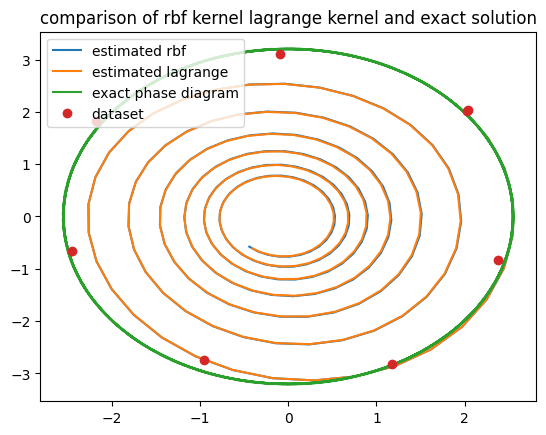

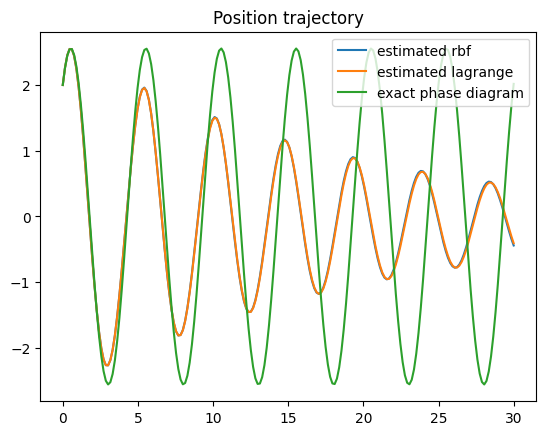

In [61]:
def ivp_learned_outputs(t, x, mode, num_datapoints, input_data, alpha, sigma):
    f = np.zeros(2)  # Output array for [velocity, acceleration]
    # Loop over all training points to compute the weighted sum of kernel values
    for j in range(num_datapoints):
        if mode == "lagrangian":
             kernel_value = lagrangian_kernel(x, input_data[j], sigma) 
        if mode == "rbf":
                kernel_value = rbf_kernel(x, input_data[j], sigma) 
        f += alpha[j] * kernel_value  # Weighted sum using learned coefficients
    return f  # Return [velocity, acceleration]
    
sol_rbf = solve_ivp(ivp_learned_outputs, entire_span, init_values, t_eval=entire_t, args=("rbf", num_datapoints, input_data, a_rbf, sigma_r))
sol_lagrange = solve_ivp(ivp_learned_outputs, entire_span, init_values, t_eval=entire_t, args=("lagrangian", num_datapoints, input_data, a_lagrange, sigma_l))
 
plt.title("comparison of rbf kernel lagrange kernel and exact solution")
plt.plot(sol_rbf.y[0], sol_rbf.y[1], label = "estimated rbf")
plt.plot(sol_lagrange.y[0], sol_lagrange.y[1], label = "estimated lagrange")
plt.plot(sol_exact.y[0], sol_exact.y[1], label = "exact phase diagram")
plt.plot(input_data[:,0], input_data[:,1], 'o', label = "dataset")
plt.legend()
plt.show()
 
plt.title("Position trajectory")
plt.plot(entire_t, sol_rbf.y[0], label = "estimated rbf")
plt.plot(entire_t, sol_lagrange.y[0], label = "estimated lagrange")
plt.plot(entire_t, sol_exact.y[0], label = "exact phase diagram")
#plt.plot(t, p, 'o', label = "dataset")
plt.legend()
plt.show()

### Computing mse for the different models

In [62]:
def evaluate_mse(true_q, pred_q, true_qdot, pred_qdot, weight_q=0.5, weight_qdot=0.5):
    # Compute individual MSE
    mse_q = np.mean((true_q - pred_q)**2)
    mse_qdot = np.mean((true_qdot - pred_qdot)**2)
    # Combine with weights
    total_mse = weight_q * mse_q + weight_qdot * mse_qdot
    return mse_q, mse_qdot, total_mse

# Example usage
mse_q_r, mse_qdot_r, total_mse_r = evaluate_mse(sol_exact.y[0], sol_rbf.y[0], sol_exact.y[1], sol_rbf.y[1])
print(f"MSE rbf (Position): {mse_q_r}")
print(f"MSE rbf (Velocity): {mse_qdot_r}")
print(f"Total rbf MSE: {total_mse_r}")

mse_q_l, mse_qdot_l, total_mse_l = evaluate_mse(sol_exact.y[0], sol_lagrange.y[0], sol_exact.y[1], sol_lagrange.y[1])
print(f"MSE lagrange (Position): {mse_q_l}")
print(f"MSE lagrange (Velocity): {mse_qdot_l}")
print(f"Total lagrange MSE: {total_mse_l}")

MSE rbf (Position): 2.3068963192693506
MSE rbf (Velocity): 3.9360857944685597
Total rbf MSE: 3.121491056868955
MSE lagrange (Position): 2.2518730340735282
MSE lagrange (Velocity): 3.8503019184233462
Total lagrange MSE: 3.051087476248437


### Energy representation

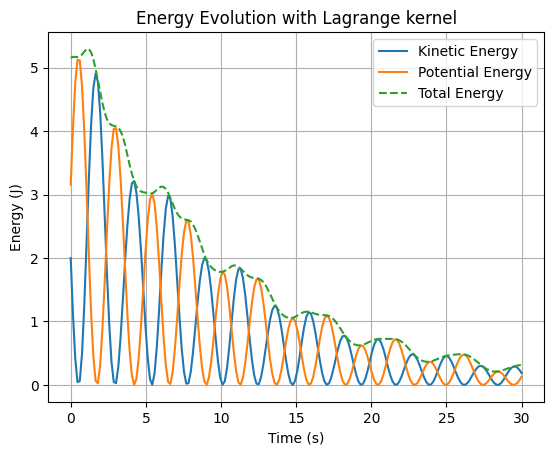

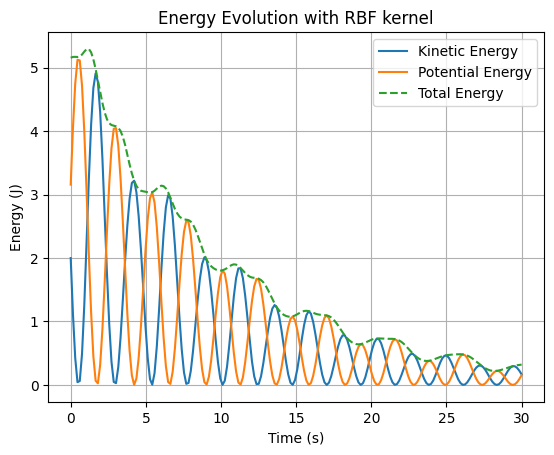

In [63]:
# Extract position and velocity from the solution
position = sol_lagrange.y[0]  # x(t)
velocity = sol_lagrange.y[1]  # dx/dt(t)

# Compute kinetic energy and potential energy
kinetic_energy = 0.5 * m * velocity**2
potential_energy = 0.5 * k * position**2
total_energy = kinetic_energy + potential_energy

# Time points
time = np.linspace(0, 30, 200)

# Plot the total energy
plt.plot(time, kinetic_energy, label="Kinetic Energy")
plt.plot(time, potential_energy, label="Potential Energy")
plt.plot(time, total_energy, label="Total Energy", linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.title("Energy Evolution with Lagrange kernel")
plt.legend()
plt.grid()
plt.show()

position = sol_rbf.y[0]  # x(t)
velocity = sol_rbf.y[1]  # dx/dt(t)

# Compute kinetic energy and potential energy
kinetic_energy = 0.5 * m * velocity**2
potential_energy = 0.5 * k * position**2
total_energy = kinetic_energy + potential_energy

plt.plot(time, kinetic_energy, label="Kinetic Energy")
plt.plot(time, potential_energy, label="Potential Energy")
plt.plot(time, total_energy, label="Total Energy", linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.title("Energy Evolution with RBF kernel")
plt.legend()
plt.grid()
plt.show()